In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
df = pd.read_csv('gene_expression_ml.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gene One        3000 non-null   float64
 1   Gene Two        3000 non-null   float64
 2   Cancer Present  3000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 70.4 KB


In [64]:
df.head()

,Gene One,Gene Two,Cancer Present
0,4.3,3.9,1
1,2.5,6.3,0
2,5.7,3.9,1
3,6.1,6.2,0
4,7.4,3.4,1


In [65]:
df['Cancer Present'].value_counts()

Cancer Present
1    1500
0    1500
Name: count, dtype: int64

<Axes: xlabel='Gene One', ylabel='Gene Two'>

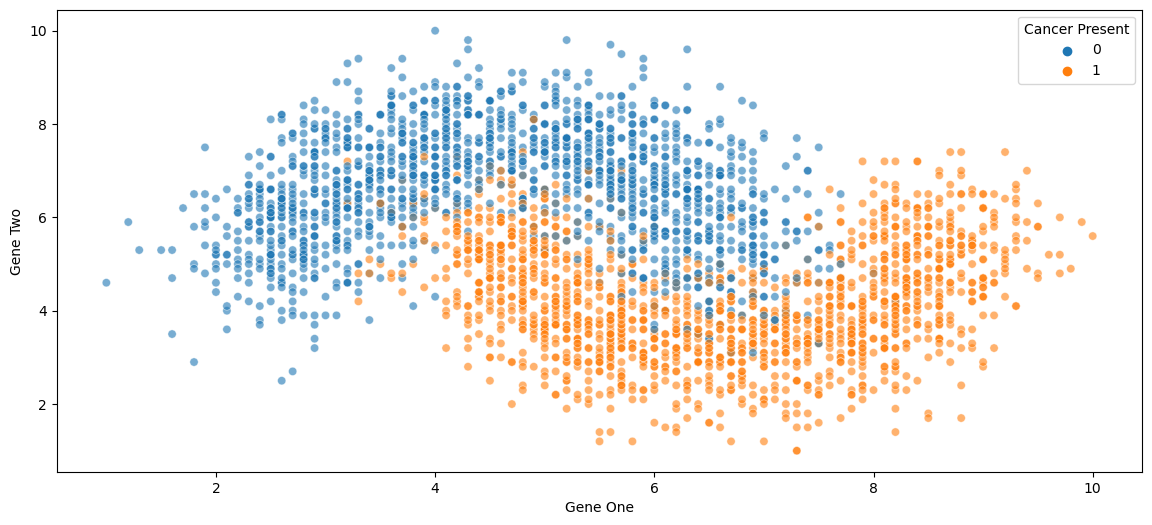

In [66]:
plt.figure(figsize=(14,6))
sns.scatterplot(x='Gene One',y='Gene Two',hue='Cancer Present',data=df, alpha=0.6)

In [67]:
X = df.drop('Cancer Present',axis=1)
y = df['Cancer Present']

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=51)

In [69]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

sc_X_train = sc.fit_transform(X_train)
sc_X_test = sc.transform(X_test)

In [70]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)

In [71]:
knn.fit(sc_X_train,y_train)

KNeighborsClassifier(n_neighbors=1)

In [72]:
y_pred = knn.predict(sc_X_test)

In [73]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [74]:
confusion_matrix(y_test,y_pred)

array([[399,  37],
       [ 49, 415]])

In [75]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90       436
           1       0.92      0.89      0.91       464

    accuracy                           0.90       900
   macro avg       0.90      0.90      0.90       900
weighted avg       0.90      0.90      0.90       900



### Elbow Method for Choosing Reasonable K Values

In [76]:
error_rates = []

for k in range(1,30):
    knn_mod = KNeighborsClassifier(n_neighbors=k)
    knn_mod.fit(sc_X_train,y_train)
    
    y_pred_test = knn_mod.predict(sc_X_test)
    
    test_error = 1 - accuracy_score(y_test,y_pred_test)
    
    error_rates.append(test_error)

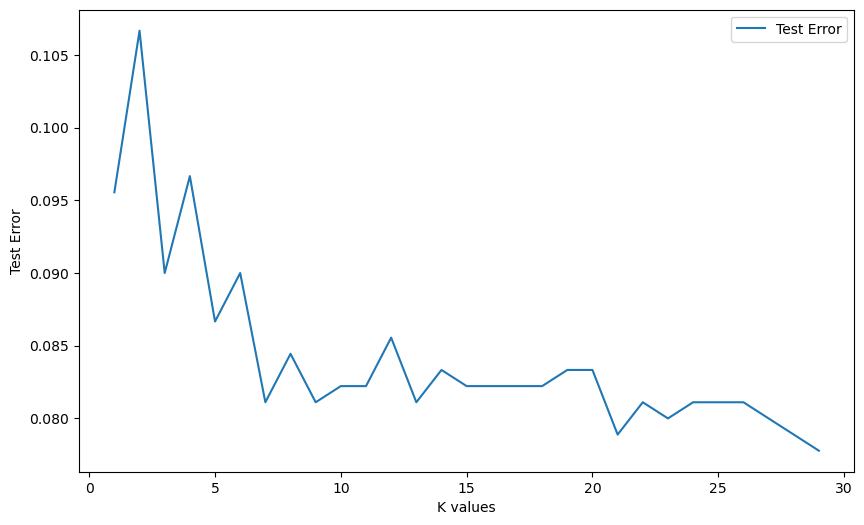

In [77]:
plt.figure(figsize=(10,6))
plt.plot(range(1,30),error_rates,label='Test Error')
plt.legend()
plt.ylabel('Test Error')
plt.xlabel('K values')
plt.show()

### Full Cross Validation Grid Search for K value


1. Train-test as per CV parameter we specify in GridSearchCV
2. scaler is fitted on Training Data
3. transforms both train and test data
4. model is trained/fitted on scaled train data
5. trained model predict using transformed Test data

In [81]:
scaler = StandardScaler()

In [82]:
knn = KNeighborsClassifier()

In [83]:
knn.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [84]:
#Make sure string code matches variable name !!

operations = [('scaler',scaler),('knn',knn)]

In [85]:
from sklearn.pipeline import Pipeline

pipe = Pipeline(operations)

In [86]:
from sklearn.model_selection import GridSearchCV

k_values = list(range(1,20))

In [87]:
param_grid = {'knn__n_neighbors':k_values}

In [89]:
full_cv = GridSearchCV(pipe,param_grid,cv=10,scoring='accuracy')

In [90]:
full_cv.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19]},
             scoring='accuracy')

In [92]:
full_cv.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=18))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=18),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 18,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [94]:
full_cv.cv_results_['mean_test_score']

array([0.91809524, 0.92      , 0.93142857, 0.93333333, 0.93666667,
       0.93619048, 0.93619048, 0.93904762, 0.9347619 , 0.93666667,
       0.9347619 , 0.94      , 0.93619048, 0.93714286, 0.93571429,
       0.94      , 0.94      , 0.94190476, 0.93904762])

### Final Model

In [95]:
scaler = StandardScaler()
knn18 = KNeighborsClassifier(n_neighbors=18)
operations = [('scaler',scaler),('knn18',knn18)]

In [96]:
pipe = Pipeline(operations)
pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn18', KNeighborsClassifier(n_neighbors=18))])

In [98]:
pipe_pred = pipe.predict(X_test)

In [99]:
confusion_matrix(pipe_pred,y_test)

array([[410,  48],
       [ 26, 416]])

In [100]:
print(classification_report(y_test,pipe_pred))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       436
           1       0.94      0.90      0.92       464

    accuracy                           0.92       900
   macro avg       0.92      0.92      0.92       900
weighted avg       0.92      0.92      0.92       900



In [101]:
X_test.iloc[0]

Gene One    5.6
Gene Two    5.6
Name: 1487, dtype: float64

In [115]:
pipe.predict([[2.9,13.9],[3.61,4.2]])

/Users/shrey/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([0, 0])

In [119]:
pipe.predict_proba([[2.9,13.9],[3.7,4.2]])

/Users/shrey/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[1.        , 0.        ],
       [0.38888889, 0.61111111]])